# __0. Imports__

In [1]:
from secret_key import Secret
import pandas as pd
import requests
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam



2024-03-17 15:54:55.774079: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 15:54:55.776860: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 15:54:55.815731: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 15:54:56.468851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h1>
    <b>1. Requesting the data</b>
</h1>
<h4><i> Here I explain the 'parameters' that the <b>api url</b> requires</i></h4>
<h2>
    <b>1.1 API Parameters</b>
</h2>
<ul>
    <li>
        <strong> Ticker</strong>
        <ul>
            <li><u>JSON FIELD:</u>
            </li>
            <li><u>DATA TYPE:</u> string
            </li>
            <li><u>REQUIRED:</u>
            </li>
        </ul>
    </li>
    <li> 
        <strong>Start Date</strong>
        <ul>
            <li><u>JSON FIELD:</u>
            </li>
            <li>DATA TYPE: date (YYYY-MM-DD)
            </li>
            <li>REQUIRED:
            </li>
        </ul>
    </li>
    <li>
        <strong>End Date</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE:date (YYYY-MM-DD)
            </li>
            <li>REQUIRED:
            </li>
        </ul>
    </li>
    <li>
        <strong> Resample Freq</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: string (e.g. "15min" or "4hour". )
            </li>
            <li>REQUIRED:
            </li>
            <li>DEFAULT:5min
            </li>
        </ul>
    </li>
    <li>
        <strong>Response Format</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: string
            </li>
            <li>REQUIRED:
            </li>
            <li>DEFAULT: JSON
            </li>
        </ul>
    </li>
</ul>


In [2]:
headers =  {
    'Content-Type' : 'application/json'
}

In [3]:
ticker = 'EURUSD'
start_date = '2024-03-01'

In [4]:
requestResponse = requests.get(f"https://api.tiingo.com/tiingo/fx/{ticker.lower()}/prices?startDate={start_date}&resampleFreq=5min&token=ebed6535a2acbe1a06b0057e8d1e8af61e5cefa7", headers=headers)

In [5]:
data = requestResponse.json() 
data 

[{'date': '2024-03-01T00:00:00.000Z',
  'ticker': 'eurusd',
  'open': 1.080585,
  'high': 1.080765,
  'low': 1.080545,
  'close': 1.080625},
 {'date': '2024-03-01T00:05:00.000Z',
  'ticker': 'eurusd',
  'open': 1.080615,
  'high': 1.080835,
  'low': 1.080545,
  'close': 1.08081},
 {'date': '2024-03-01T00:10:00.000Z',
  'ticker': 'eurusd',
  'open': 1.08082,
  'high': 1.08089,
  'low': 1.08082,
  'close': 1.080885},
 {'date': '2024-03-01T00:15:00.000Z',
  'ticker': 'eurusd',
  'open': 1.08088,
  'high': 1.080945,
  'low': 1.08081,
  'close': 1.08088},
 {'date': '2024-03-01T00:20:00.000Z',
  'ticker': 'eurusd',
  'open': 1.080885,
  'high': 1.080935,
  'low': 1.080865,
  'close': 1.08088},
 {'date': '2024-03-01T00:25:00.000Z',
  'ticker': 'eurusd',
  'open': 1.080875,
  'high': 1.080905,
  'low': 1.080775,
  'close': 1.080775},
 {'date': '2024-03-01T00:30:00.000Z',
  'ticker': 'eurusd',
  'open': 1.08078,
  'high': 1.08082,
  'low': 1.080775,
  'close': 1.080785},
 {'date': '2024-03-01T0

# __2. Analysis & Processing__

<h2><strong>2.1 Basic Analysis</strong></h2>

In [6]:
df= pd.DataFrame(data)
df.shape

(3134, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3134 non-null   object 
 1   ticker  3134 non-null   object 
 2   open    3134 non-null   float64
 3   high    3134 non-null   float64
 4   low     3134 non-null   float64
 5   close   3134 non-null   float64
dtypes: float64(4), object(2)
memory usage: 147.0+ KB


In [8]:
df.sample(5)

,date,ticker,open,high,low,close
1661,2024-03-08T18:50:00.000Z,eurusd,1.093645,1.093775,1.093565,1.093635
2036,2024-03-12T01:15:00.000Z,eurusd,1.092715,1.092825,1.092695,1.092775
1890,2024-03-11T13:00:00.000Z,eurusd,1.092960,1.093185,1.092795,1.092955
2576,2024-03-13T22:25:00.000Z,eurusd,1.095015,1.095090,1.095000,1.095065
1605,2024-03-08T14:10:00.000Z,eurusd,1.095100,1.095765,1.095075,1.095155


In [9]:
df.columns

Index(['date', 'ticker', 'open', 'high', 'low', 'close'], dtype='object')

In [10]:
type(df['date'])


pandas.core.series.Series

In [11]:
df['date'] = pd.to_datetime(df['date'])


In [12]:
df.set_index('date', inplace=True)


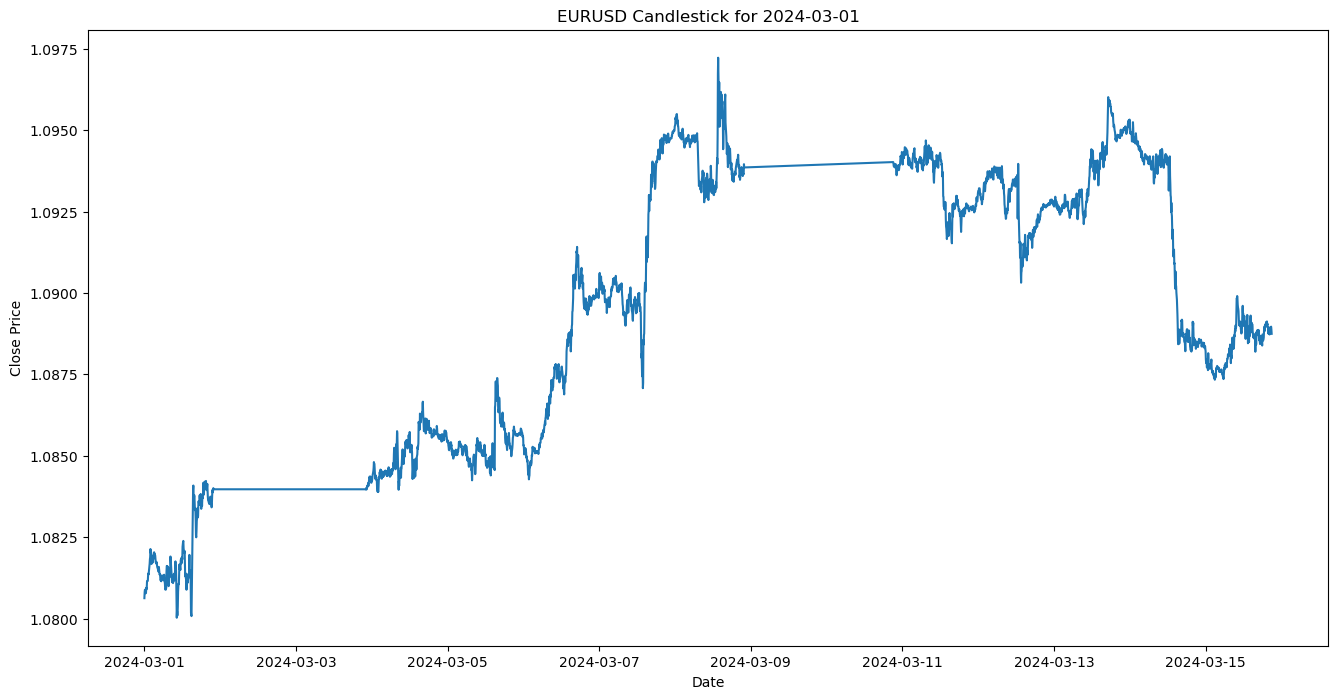

In [13]:
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Candlestick for {start_date}')
plt.plot(df['close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

<h2><strong>2.2 Preprocessing</strong></h2>

<h3><strong>2.2.1 Scaling<strong></h3>

In [14]:
# scaler = StandardScaler()
# numerical_features = ['open', 'high', 'low', 'close']  # Assuming these are your numerical features
# df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [15]:
# df_close = df['close']
# df_close
df.head()

,ticker,open,high,low,close
date,,,,,
2024-03-01 00:00:00+00:00,eurusd,1.080585,1.080765,1.080545,1.080625
2024-03-01 00:05:00+00:00,eurusd,1.080615,1.080835,1.080545,1.080810
2024-03-01 00:10:00+00:00,eurusd,1.080820,1.080890,1.080820,1.080885
2024-03-01 00:15:00+00:00,eurusd,1.080880,1.080945,1.080810,1.080880
2024-03-01 00:20:00+00:00,eurusd,1.080885,1.080935,1.080865,1.080880


<h3><strong>2.2.2 Creating training data<strong></h3>

In [16]:
def create_lagged_dataframe(df, lag_steps=3):
    lagged_df = pd.DataFrame(index=df.index)
    lagged_df['DateTime'] = df.index
    lagged_df['ActualValue'] = df['close']

    # Create lagged columns for previous values
    for i in range(1, lag_steps + 1):
        lagged_df[f'PrevValue_{i}'] = df['close'].shift(i)

    return lagged_df.dropna()

# Assuming df is your original DataFrame containing the time series data
lagged_df = create_lagged_dataframe(df)
lagged_df.head()


,DateTime,ActualValue,PrevValue_1,PrevValue_2,PrevValue_3
date,,,,,
2024-03-01 00:15:00+00:00,2024-03-01 00:15:00+00:00,1.080880,1.080885,1.080810,1.080625
2024-03-01 00:20:00+00:00,2024-03-01 00:20:00+00:00,1.080880,1.080880,1.080885,1.080810
2024-03-01 00:25:00+00:00,2024-03-01 00:25:00+00:00,1.080775,1.080880,1.080880,1.080885
2024-03-01 00:30:00+00:00,2024-03-01 00:30:00+00:00,1.080785,1.080775,1.080880,1.080880
2024-03-01 00:35:00+00:00,2024-03-01 00:35:00+00:00,1.080945,1.080785,1.080775,1.080880


In [17]:
import numpy as np

def prepare_lstm_data(lagged_df):
    dates = lagged_df['DateTime']
    X = lagged_df.drop(columns=['DateTime', 'ActualValue']).astype(np.float32)
    y = lagged_df['ActualValue'].astype(np.float32)

    return dates, X.values, y.values

# Assuming lagged_df is the DataFrame obtained from the previous function
dates, X, y = prepare_lstm_data(lagged_df)
print("Dates:", dates.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)


Dates: (3131,)
X shape: (3131, 3)
y shape: (3131,)


<h3><strong>2.2.3 <u>Spliting:</u> Training, Validation, Testing Data<strong></h3>

In [18]:
def split_data(dates, X, y):
    # Calculate the number of data points for each split
    total_points = len(dates)
    train_size = int(total_points * 0.6)
    val_size = int(total_points * 0.2)
    test_size = total_points - train_size - val_size
    
    # Split the data based on the calculated sizes
    x_train, x_val, x_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]
    
    return (train_dates, x_train, y_train), (val_dates, x_val, y_val), (test_dates, x_test, y_test)

# Assuming you have already prepared the dates, X, and y variables
(train_dates, x_train, y_train), (val_dates, x_val, y_val), (test_dates, x_test, y_test) = split_data(dates, X, y)


NameError: name 'train_dates' is not defined

In [ ]:
# Calculate the total number of instances
total_instances = len(dates) + len(val_dates) + len(test_dates)

# Print information about each set
print("Training set:", len(train_dates), "instances (", len(train_dates) / total_instances * 100, "%)")
print("Validation set:", len(val_dates), "instances (", len(val_dates) / total_instances * 100, "%)")
print("Testing set:", len(test_dates), "instances (", len(test_dates) / total_instances * 100, "%)")


Training set: 1878 instances ( 42.83759124087591 %)
Validation set: 626 instances ( 14.279197080291972 %)
Testing set: 627 instances ( 14.302007299270073 %)


<h3><strong>2.2.4 Training the model<strong></h3>

In [ ]:
model = Sequential([layers.Input((3,1)), # 3 because we are doing 3 days in the past
                    layers.LSTM(60),
                    layers.Dense(32, activation= 'relu'),
                    layers.Dense(32, activation= 'relu'),
                    layers.Dense(1)]) 

model.compile(loss = 'mse', 
              optimizer =  Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error']
              )

2024-03-17 15:43:16.958731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 15:43:16.959238: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
model.fit(x_train,y_train, epochs = 100, verbose=1)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1622e-06 - mean_absolute_error: 0.0012
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0022e-06 - mean_absolute_error: 0.0012
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8445e-06 - mean_absolute_error: 0.0016
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9610e-06 - mean_absolute_error: 0.0014
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7389e-06 - mean_absolute_error: 0.0015
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3192e-06 - mean_absolute_error: 0.0015   
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4428e-06 - mean_absolute_error: 0.0013
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2117e-06 - mean_absolute_error: 0.0015
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0768e-06 - mean_absolute_error: 0.0012  
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8129e-06 - mean_absolute_error: 0

<h1><strong>3. Model Evaluation</strong></h1>

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2396e-05 - mean_absolute_error: 0.0035

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7068e-06 - mean_absolute_error: 0.0031 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


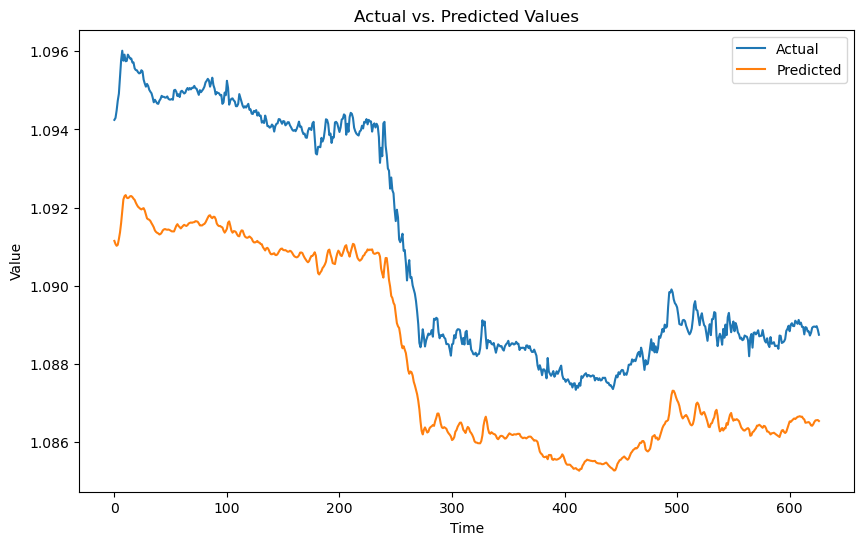

KeyError: 'loss'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Evaluate the model
loss, mae = model.evaluate(x_test, y_test)

# Predict on the test data
predictions = model.predict(x_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the loss curve
history = model.history.history
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
